## Install required libraries

To download dataset from kaggle, we installed kaggle package

In [1]:
!pip install kaggle

## Get Kaggle API Token

First get credentials from your kaggle account. You will kaggle.json file.

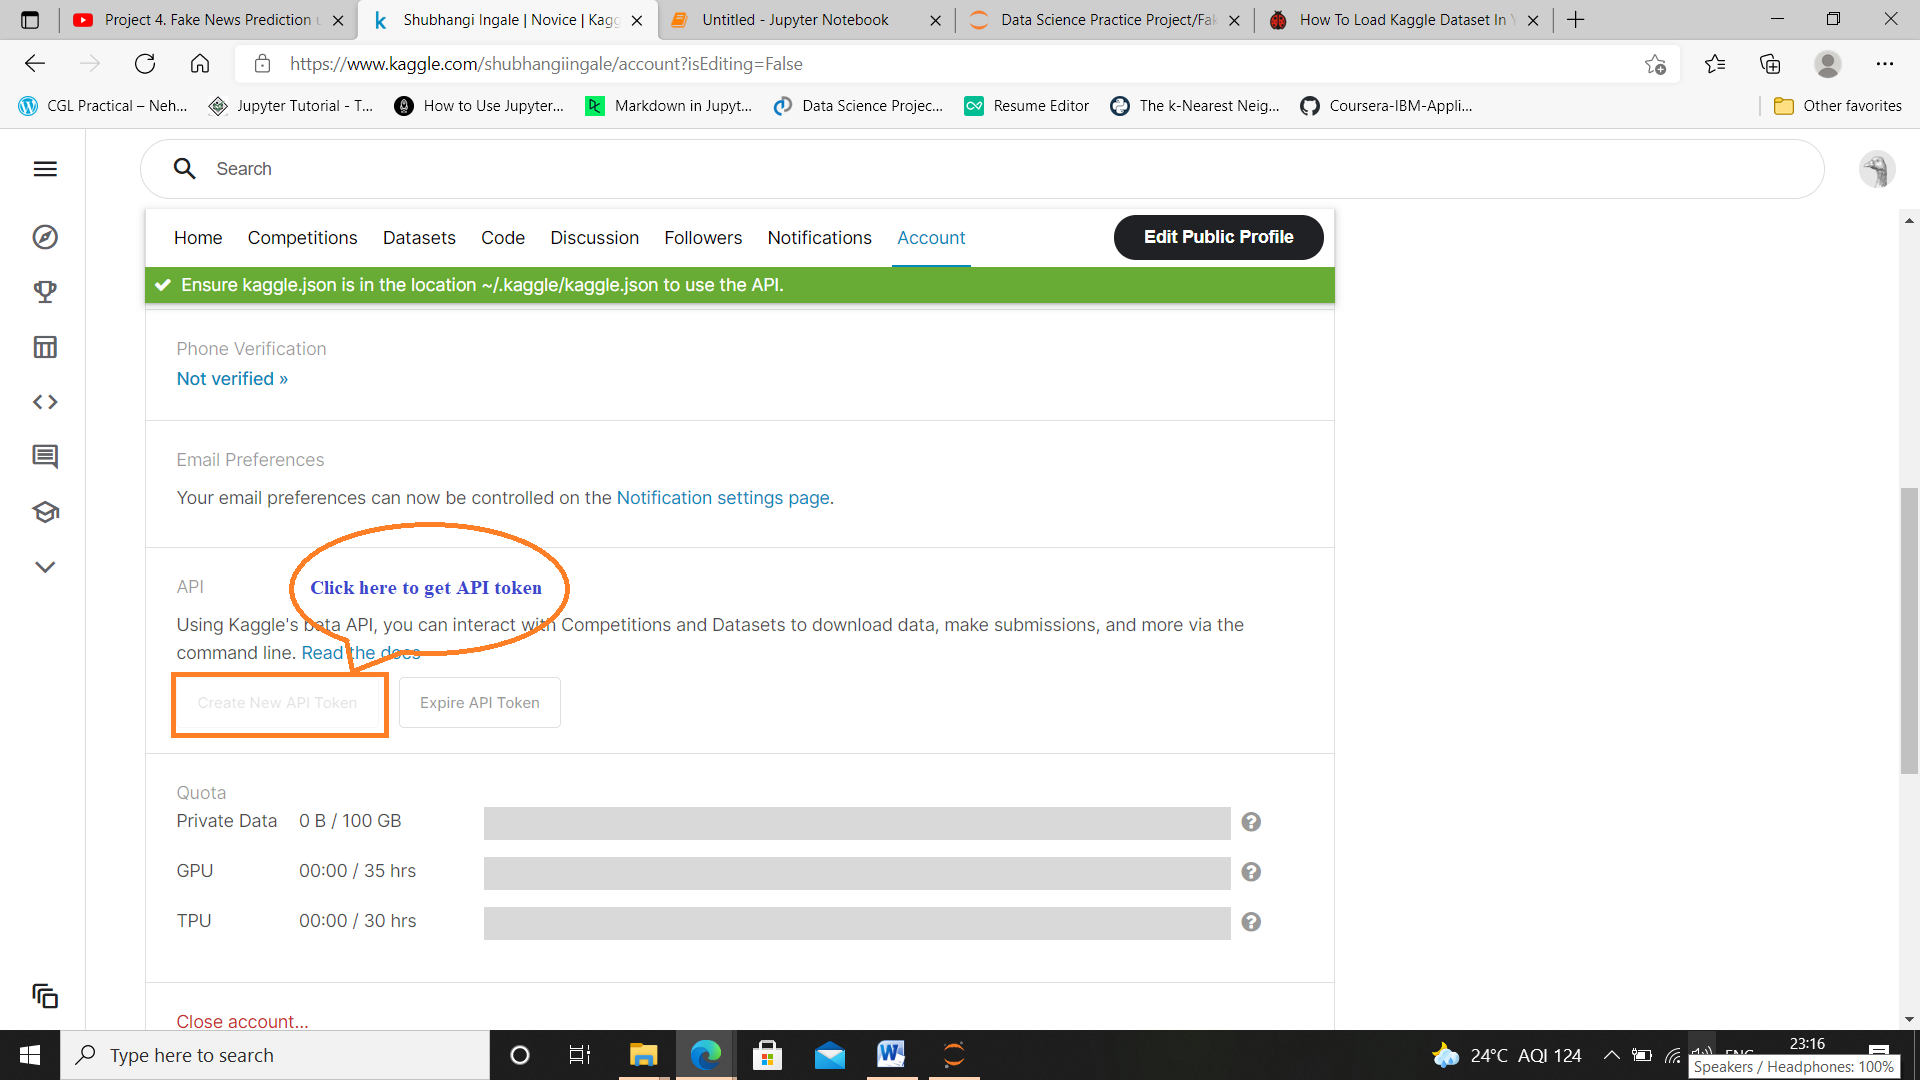

Make a kaggle folder. Copy that kaggle.json file in this newly created folder.

In [2]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir .kaggle

A subdirectory or file .kaggle already exists.


Import kaggle package and download fake-news.zip forlder by using a command given on kaggle website.

In [3]:
import kaggle
!kaggle competitions download -c fake-news

fake-news.zip: Skipping, found more recently modified local copy (use --force to force download)


Extract fake-news.zip folder. Then you can read dataset.

In [4]:
from zipfile import ZipFile
file_name = 'fake-news.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Fake-news Data Description
It consists of three different datasets as follows:
 
1. train.csv: A full training dataset with the following attributes:
- id: unique id for a news article

- title: the title of a news article

- author: author of the news article

- text: the text of the article; could be incomplete

- label: a label that marks the article as potentially unreliable

    - 1: unreliable
    - 0: reliable

2. test.csv: A testing training dataset with all the same attributes at train.csv without the label.

3. submit.csv: A sample submission that you can

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords          #nltk is natural language toolkit.
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")
submit_dataset = pd.read_csv("submit.csv")
train_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
test_dataset.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [8]:
print(test_dataset.shape)

(5200, 4)


In [9]:
submit_dataset.drop(['id'],axis = 'columns', inplace = True)
submit_dataset

,label
0,0
1,1
2,0
3,1
4,1
...,...
5195,0
5196,1
5197,0
5198,1


In [10]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


## Data Cleaning

In [11]:
train_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

We can understand that train_dataset contains colunms(title, author, text) with null values. But this data is of type missing completely at random(MCAR). And we can replace those null values by any other value. So, it will be better to drop all those null values.

In [12]:
train_dataset = train_dataset.fillna('')

In [13]:
train_dataset['content'] = train_dataset['title'] + ' ' + train_dataset['author']

In [14]:
train_dataset.drop(['id'],axis='columns', inplace = True)
train_dataset

,title,author,text,label,content
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...
...,...,...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,Rapper T.I.: Trump a ’Poster Child For White S...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,Macy’s Is Said to Receive Takeover Approach by...
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [15]:
train_dataset.isnull().sum()

title      0
author     0
text       0
label      0
content    0
dtype: int64

In [16]:
test_dataset.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [17]:
test_dataset = test_dataset.fillna('')
print(test_dataset.shape)

(5200, 4)


In [18]:
test_dataset.drop(['id'],axis = 1, inplace = True)
test_dataset['content'] = test_dataset['title'] + ' ' + test_dataset['author']
test_dataset

,title,author,text,content
0,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...
3,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ..."
4,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) Truth Broadcas...
...,...,...,...,...
5195,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,The Bangladeshi Traffic Jam That Never Ends - ...
5196,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,John Kasich Signs One Abortion Bill in Ohio bu...
5197,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,"California Today: What, Exactly, Is in Your Su..."
5198,300 US Marines To Be Deployed To Russian Borde...,,« Previous - Next » 300 US Marines To Be Deplo...,300 US Marines To Be Deployed To Russian Borde...


In [19]:
test_dataset.isnull().sum()

title      0
author     0
text       0
content    0
dtype: int64

Display histogram of column label from train_dataset to analyze. 

<AxesSubplot:>

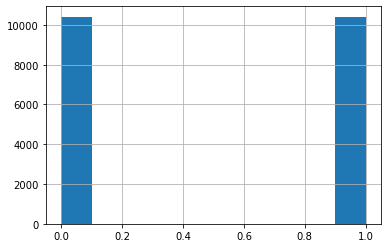

In [20]:
train_dataset['label'].hist()

Read dependent features and independent features.

In [21]:
x_train_data = train_dataset.drop(['label','title','author','text'], axis =1)
x_train_data

,content
0,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...
...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,Macy’s Is Said to Receive Takeover Approach by...
20798,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [22]:
y_train_data = train_dataset['label']
y_train_data

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20800, dtype: int64

In [23]:
y_train_data.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [24]:
y_test_data = submit_dataset['label']
y_test_data

0       0
1       1
2       0
3       1
4       1
       ..
5195    0
5196    1
5197    0
5198    1
5199    0
Name: label, Length: 5200, dtype: int64

Download stopwords by using nltk

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shubhangi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
print(stopwords.words('English'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Data Pre-processing

Removed urls, emojis and punctuations , stopwords and Lower cased clean text

##### Stemming

Stemming is a process of reducing a word to it's rood word.

In [27]:
word_stemmer = PorterStemmer()

In [28]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shubhangi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
corpus_train =[]

def text_stemming(df):
    df['content']= df.apply(lambda row: re.sub("[^a-zA-Z]", " ", row['content']).lower(), axis = 1)
    corpus = []
    for row in df['content']:
        tokens = row.split()
        tokens = [word_stemmer.stem(word) for word in tokens if not word in stopwords.words('english')]
        tokens = ' '.join(tokens)
        corpus.append(tokens)
    return corpus

corpus_train = text_stemming(train_dataset)

In [30]:
corpus_train[:5]

['hous dem aid even see comey letter jason chaffetz tweet darrel lucu',
 'flynn hillari clinton big woman campu breitbart daniel j flynn',
 'truth might get fire consortiumnew com',
 'civilian kill singl us airstrik identifi jessica purkiss',
 'iranian woman jail fiction unpublish stori woman stone death adulteri howard portnoy']

In [31]:
corpus_test = text_stemming(test_dataset)
corpus_test[:5]

['specter trump loosen tongu purs string silicon valley new york time david streitfeld',
 'russian warship readi strike terrorist near aleppo',
 'nodapl nativ american leader vow stay winter file lawsuit polic common dream',
 'tim tebow attempt anoth comeback time basebal new york time daniel victor',
 'keiser report meme war e truth broadcast network']

After Cleaning the data now convert the string or text data into numerical values for the undersatnding of the machines.

### TF-IDF
<b>TF-IDF</b> stands for Term Frequency - Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.

<b>TF-IDF Formula</b>
1. Term Frequency Formula:
$$tf(w,d) = log(1 + f(w,d))$$
where,
- $N$ is the number of documents we have in our dataset
- $d$ is a given document from our dataset
- $D$ is the collection of all documents
- $w$ is a given word in a document
- $f(w,d)$ is the frequency of word $w$ in document $d$.

2. Inverse Document Frequency Formula:
$$idf(w,D) = \log(\frac{N}{f(w,D)})$$

With N documents in the dataset and f(w, D) the frequency of word w in the whole dataset, this number will be lower with more appearances of the word in the whole dataset.

3. TF-IDF score formula:
$$tfidf(w,d,D) = tf(w,d) * idf(w,D)$$

### Converting  textual data to numeric data

#### 1. TFID vectorizer

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer

In [33]:
vectorizer1 = TfidfVectorizer(max_features = 5000, ngram_range = (1,3))
X_train = vectorizer1.fit_transform(corpus_train).toarray()
print(X_train.shape)
print(X_train)

# df = pd.DataFrame(X_train, columns= vectorizer.get_feature_names())
# df

(20800, 5000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1,3))
X_test = vectorizer.fit_transform(corpus_test).toarray()
print(X_test.shape)
print(X_test)
Y_test = submit_dataset['label']
# Y_test

(5200, 5000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 2. Count Vectorizer

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(max_features = 5000, ngram_range=(1, 2), stop_words='english') 
# Fit and transform the training data.
count_train = count_vectorizer.fit_transform(corpus_train)
# Transform the test set 
count_test = count_vectorizer.transform(corpus_test)
print(count_train.shape)
print(count_test.shape)

(20800, 5000)
(5200, 5000)


### Splitting dataset into training dataset and test dataset

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train,y_train_data, test_size=0.2, stratify = y_train_data, random_state=1)

# Builing Models
## Using TFIDVectorizer

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

accuracy_algo_tfid = list()
print(type(accuracy_algo_tfid))

<class 'list'>


### 1. Logistic regression classification

In [39]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)
lr_pred = lr_model.predict(x_test)
print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test, lr_pred)*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test, lr_pred))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test, lr_pred))

accuracy = round(accuracy_score(y_test, lr_pred)*100,2)
accuracy_algo_tfid = [accuracy]
print(accuracy_algo_tfid)

Accuracy of Logistic Regression Classifier: 98.46%

Confusion Matrix of Logistic Regression Classifier:

[[2027   50]
 [  14 2069]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2077
           1       0.98      0.99      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160

[98.46]


### 2. Support Vector Classifer

In [40]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(x_train, y_train)
svm_pred= svm_model.predict(x_test)

print("Accuracy of Support Vector Classifier: {}%".format(round(accuracy_score(y_test, svm_pred)*100,2)))
print("\nConfusion Matrix of Support Vector Classifier:\n")
print(confusion_matrix(y_test, svm_pred))
print("\nCLassification Report of Support Vector Classifier:\n")
print(classification_report(y_test, svm_pred))
accuracy_algo_tfid.append(round(accuracy_score(y_test, svm_pred)*100,2))

Accuracy of Support Vector Classifier: 99.52%

Confusion Matrix of Support Vector Classifier:

[[2066   11]
 [   9 2074]]

CLassification Report of Support Vector Classifier:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2077
           1       0.99      1.00      1.00      2083

    accuracy                           1.00      4160
   macro avg       1.00      1.00      1.00      4160
weighted avg       1.00      1.00      1.00      4160



### 3. Multinominal Navie Bayes Classiffier

In [41]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
nb_pred= nb_model.predict(x_test)

print("Accuracy of Naive Bayes Classifier: {}%".format(round(accuracy_score(y_test, nb_pred)*100,2)))
print("\nConfusion Matrix of Naive Bayes Classifier:\n")
print(confusion_matrix(y_test, nb_pred))
print("\nCLassification Report of Support Vector Classifier:\n")
print(classification_report(y_test, nb_pred))
accuracy_algo_tfid.append(round(accuracy_score(y_test, nb_pred)*100,2))

Accuracy of Naive Bayes Classifier: 97.02%

Confusion Matrix of Naive Bayes Classifier:

[[2055   22]
 [ 102 1981]]

CLassification Report of Support Vector Classifier:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2077
           1       0.99      0.95      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



### 4. Passive Aggressive Classifier

In [42]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [43]:
linear_classifier = PassiveAggressiveClassifier(max_iter=10)
linear_classifier.fit(x_train, y_train)
pred_linear_count = linear_classifier.predict(x_test)
print("Accuracy of Passive Aggressive Classifier: {}%".format(round(accuracy_score(y_test, pred_linear_count)*100,2)))
print("\nConfusion Matrix of Passive Aggressive Classifier:\n")
print(confusion_matrix(y_test, pred_linear_count))
print("\nCLassification Report of Passive Aggressive Classifier:\n")
print(classification_report(y_test, pred_linear_count))
accuracy_algo_tfid.append(round(accuracy_score(y_test, pred_linear_count)*100,2))

Accuracy of Passive Aggressive Classifier: 99.38%

Confusion Matrix of Passive Aggressive Classifier:

[[2065   12]
 [  14 2069]]

CLassification Report of Passive Aggressive Classifier:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2077
           1       0.99      0.99      0.99      2083

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### 5. Decision Tree Classifier

In [44]:
from sklearn import tree
decision_tree_classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 300, max_depth = 3, min_samples_leaf = 5)
decision_tree_classifier.fit(x_train,y_train)
dct_pred = decision_tree_classifier.predict(x_test)
print("Accuracy of Decision Tree Classifier: {}%".format(round(accuracy_score(y_test, dct_pred)*100,2)))
print("\nConfusion Matrix of Decision Tree Classifier:\n")
print(confusion_matrix(y_test, dct_pred))
print("\nCLassification Report of Decision Tree Classifier:\n")
print(classification_report(y_test, dct_pred))
accuracy_algo_tfid.append(round(accuracy_score(y_test, dct_pred)*100,2))

Accuracy of Decision Tree Classifier: 92.19%

Confusion Matrix of Decision Tree Classifier:

[[1757  320]
 [   5 2078]]

CLassification Report of Decision Tree Classifier:

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2077
           1       0.87      1.00      0.93      2083

    accuracy                           0.92      4160
   macro avg       0.93      0.92      0.92      4160
weighted avg       0.93      0.92      0.92      4160



In [45]:
print(accuracy_algo_tfid)

[98.46, 99.52, 97.02, 99.38, 92.19]


## Count Vectorizer

#### 1. Logistic Regression

In [46]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(count_train,y_train_data, test_size=0.2, stratify = y_train_data, random_state=1)

In [47]:
lr_model = LogisticRegression()
lr_model.fit(x_train1,y_train1)
lr_pred = lr_model.predict(x_test1)
print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test1, lr_pred)*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test1, lr_pred))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test1, lr_pred))

accuracy_algo_count = [round(accuracy_score(y_test1, lr_pred)*100,2)]

Accuracy of Logistic Regression Classifier: 99.38%

Confusion Matrix of Logistic Regression Classifier:

[[2058   19]
 [   7 2076]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2077
           1       0.99      1.00      0.99      2083

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



### 2. Support Vector Classifier

In [48]:
svm_model = LinearSVC()
svm_model.fit(x_train1, y_train)
svm_pred= svm_model.predict(x_test1)

print("Accuracy of Support Vector Classifier: {}%".format(round(accuracy_score(y_test1, svm_pred)*100,2)))
print("\nConfusion Matrix of Support Vector Classifier:\n")
print(confusion_matrix(y_test1, svm_pred))
print("\nCLassification Report of Support Vector Classifier:\n")
print(classification_report(y_test1, svm_pred))

accuracy_algo_count.append(round(accuracy_score(y_test1, svm_pred)*100,2))

Accuracy of Support Vector Classifier: 99.54%

Confusion Matrix of Support Vector Classifier:

[[2066   11]
 [   8 2075]]

CLassification Report of Support Vector Classifier:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2077
           1       0.99      1.00      1.00      2083

    accuracy                           1.00      4160
   macro avg       1.00      1.00      1.00      4160
weighted avg       1.00      1.00      1.00      4160



### 3. Multinominal Navie Bayes Classiffier

In [49]:
nb_model = MultinomialNB()
nb_model.fit(x_train1, y_train1)
nb_pred= nb_model.predict(x_test1)

print("Accuracy of Naive Bayes Classifier: {}%".format(round(accuracy_score(y_test1, nb_pred)*100,2)))
print("\nConfusion Matrix of Naive Bayes Classifier:\n")
print(confusion_matrix(y_test1, nb_pred))
print("\nCLassification Report of Support Vector Classifier:\n")
print(classification_report(y_test1, nb_pred))

accuracy_algo_count.append(round(accuracy_score(y_test1, nb_pred)*100,2))

Accuracy of Naive Bayes Classifier: 97.31%

Confusion Matrix of Naive Bayes Classifier:

[[2061   16]
 [  96 1987]]

CLassification Report of Support Vector Classifier:

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2077
           1       0.99      0.95      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



### 4. Passive Aggressive Classifier

In [50]:
pred_linear_count = linear_classifier.predict(x_test1)
print("Accuracy of Passive Aggressive Classifier: {}%".format(round(accuracy_score(y_test1, pred_linear_count)*100,2)))
print("\nConfusion Matrix of Passive Aggressive Classifier:\n")
print(confusion_matrix(y_test1, pred_linear_count))
print("\nCLassification Report of Passive Aggressive Classifier:\n")
print(classification_report(y_test1, pred_linear_count))

accuracy_algo_count.append(round(accuracy_score(y_test1, pred_linear_count)*100,2))

Accuracy of Passive Aggressive Classifier: 58.75%

Confusion Matrix of Passive Aggressive Classifier:

[[1183  894]
 [ 822 1261]]

CLassification Report of Passive Aggressive Classifier:

              precision    recall  f1-score   support

           0       0.59      0.57      0.58      2077
           1       0.59      0.61      0.60      2083

    accuracy                           0.59      4160
   macro avg       0.59      0.59      0.59      4160
weighted avg       0.59      0.59      0.59      4160



### 5. Decision Tree Classifier

In [51]:
decision_tree_classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 300, max_depth = 3, min_samples_leaf = 5)
decision_tree_classifier.fit(x_train1,y_train1)
dct_pred1 = decision_tree_classifier.predict(x_test1)
print("Accuracy of Decision Tree Classifier: {}%".format(round(accuracy_score(y_test1, dct_pred1)*100,2)))
print("\nConfusion Matrix of Decision Tree Classifier:\n")
print(confusion_matrix(y_test1, dct_pred1))
print("\nCLassification Report of Decision Tree Classifier:\n")
print(classification_report(y_test1, dct_pred1))

accuracy_algo_count.append(round(accuracy_score(y_test1, dct_pred1)*100,2))

Accuracy of Decision Tree Classifier: 92.19%

Confusion Matrix of Decision Tree Classifier:

[[1757  320]
 [   5 2078]]

CLassification Report of Decision Tree Classifier:

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2077
           1       0.87      1.00      0.93      2083

    accuracy                           0.92      4160
   macro avg       0.93      0.92      0.92      4160
weighted avg       0.93      0.92      0.92      4160



In [52]:
print(accuracy_algo_count)

[99.38, 99.54, 97.31, 58.75, 92.19]


## Conclusion:

Following table shows comparative accuracy values of various machine learining algorithms:
<table>
    <tr><th rowspan = "2">Algorithm</th><th colspan = "2"> Accuracy</th></tr>
    <tr><th>Tfid Vectorizer</th><th>Count Vectorizer</th></tr>
    <tr><td>Logistic Regression Classifier</td><td>98.46</td><td>99.38</td></tr>
    <tr><td>Supprt Vector Classfier</td><td>99.52</td><td>99.54</td></tr>
    <tr><td>Multinomial Navie Bayes Classfier</td><td>97.31</td><td>97.31</td></tr>
    <tr><td>Passive Aggressive Classifier</td><td>99.47</td><td>99.47</td></tr>
    <tr><td>Decision tree Classifier</td><td>92.19</td><td>92.19</td></tr>
</table>


From above table, we can say that Support Vector Classifier using Count Vectorizer has highest accuracy value. So, this model is best.

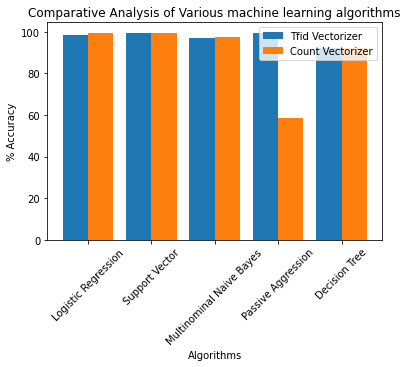

In [57]:
import matplotlib.pyplot as plt 
  
Algorithms_x = ['Logistic Regression','Support Vector','Multinominal Naive Bayes','Passive Aggression','Decision Tree']

X_axis = np.arange(len(Algorithms_x))
  
plt.bar(X_axis - 0.2, accuracy_algo_tfid, 0.4, label = 'Tfid Vectorizer')
plt.bar(X_axis + 0.2, accuracy_algo_count, 0.4, label = 'Count Vectorizer')
  
plt.xticks(X_axis, Algorithms_x, rotation=45)
plt.xlabel("Algorithms")
plt.ylabel("% Accuracy")
plt.title("Comparative Analysis of Various machine learning algorithms")
plt.legend()
plt.show()

In [166]:
svm_pred= svm_model.predict(X_test)

print("Accuracy of Support Vector Classifier: {}%".format(round(accuracy_score(Y_test, svm_pred)*100,2)))
print("\nConfusion Matrix of Support Vector Classifier:\n")
print(confusion_matrix(Y_test, svm_pred))
print("\nCLassification Report of Support Vector Classifier:\n")
print(classification_report(Y_test, svm_pred))

Accuracy of Support Vector Classifier: 55.02%

Confusion Matrix of Support Vector Classifier:

[[   0 2339]
 [   0 2861]]

CLassification Report of Support Vector Classifier:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2339
           1       0.55      1.00      0.71      2861

    accuracy                           0.55      5200
   macro avg       0.28      0.50      0.35      5200
weighted avg       0.30      0.55      0.39      5200



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
